In [4]:
from torchvision import datasets
import torch

import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
data_folder = "C:/Users/user/data/FMNIST/"
fmnist = datasets.FashionMNIST(data_folder, train=True, download=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [11]:
class FMNISTDataset(Dataset):
    
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y
        
    def __getitem__(self, ix):
        return self.x[ix].to(device), self.y[ix].to(device)
    
    def __len__(self):
        return len(self.x)

import torch.nn as nn
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
    ).to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= 1e-3)
    return model, loss, optimizer

def train_batch(x, y, model, opt, loss):
    model.train()
    
    opt.zero_grad()
    pred = model(x)
    batch_loss = loss(pred, y)
    batch_loss.backward()
    
    opt.step()
    return batch_loss.item()



def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()



def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl




@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss(prediction, y)
    return val_loss.item()



trainloader, validloader = get_data()
model, loss, optimizer = get_model()
  

In [12]:
from torch import optim
import numpy as np
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
            factor=0.5, patience=0, threshold=0.001, verbose=True, min_lr=1e-5, threshold_mode = 'abs')
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print("Epoch: ",epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trainloader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trainloader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(validloader)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00010: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00011: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00013: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00014: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.


KeyboardInterrupt: 

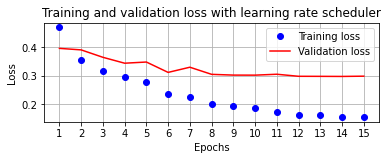

C:\Users\user\AppData\Local\Temp\ipykernel_5952\4276338239.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


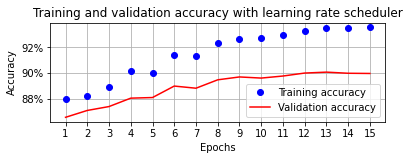

In [15]:
epochs = np.arange(15)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline


plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with learning rate scheduler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')


plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with learning rate scheduler')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()